In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
BIN_DIR = '/content/drive/MyDrive/AML_Project/binaries'
DATA_DIR = '/content/drive/My Drive/AML_Project/dbpedia_csv'

In [3]:
# To get better stacktrace when training on GPU
# https://stackoverflow.com/questions/51691563/cuda-runtime-error-59-device-side-assert-triggered
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
# For debugging
import torch
torch.autograd.set_detect_anomaly(True)

In [5]:
import torch

def get_device():
    if torch.cuda.is_available():  
        device = "cuda:0" 
    else:  
        device = "cpu"  

    return torch.device(device)

device = get_device()
device

device(type='cuda', index=0)

# Preprocessing data and building vocabulary

In [6]:
import torch
import os
from torchtext.data import Field, TabularDataset, BucketIterator

# fields
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.long)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('label', label_field), ('text', text_field)]

# tabular dataset for entire dataset
train, validation, test = TabularDataset.splits(path=os.path.join(DATA_DIR, 'lstm'), train='train.csv', 
                                     validation='validation.csv', test='test.csv', format='CSV',
                                     fields=fields, skip_header=True)

# tabular dataset for label split 2
train_split2, validation_split2 = TabularDataset.splits(path=DATA_DIR, train='dbpedia_train_split2.csv', 
                                     validation='dbpedia_validation_split2.csv', format='CSV',
                                     fields=fields)
# iterators
train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
val_iter = BucketIterator(validation, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

train_split2_iter = BucketIterator(train_split2, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
val_split2_iter = BucketIterator(validation_split2, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

In [7]:
# vocabulary
text_field.build_vocab(train)
len(text_field.vocab)

33679

# Building LSTM Model

In [8]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class LSTM(nn.Module):

    def __init__(self, vocab_size, embed_size=300, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=embed_size,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 4)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        # pack_padded_sequence had some issues running on gpu
        # https://discuss.pytorch.org/t/pack-padded-sequence-on-gpu/14140
        # https://github.com/pytorch/xla/issues/1522
        packed_input = pack_padded_sequence(text_emb.cpu(), text_len.cpu(), batch_first=True, enforce_sorted=False).to(device)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea1 = self.fc(text_fea)
        text_fea_squeeze = torch.squeeze(text_fea1, 1)
        text_out = torch.sigmoid(text_fea_squeeze)

        return text_out

# Virtual Adversarial Loss Training

In [9]:
# PyTorch implementation of Virtual Adversarial Training Loss
import contextlib
import torch
import torch.nn as nn
    
def normalize(d):
    d /= (torch.sqrt(torch.sum(d**2, axis=1)).view(-1,1)+1e-16)
    return d

def _l2_normalize(d):
    d_reshaped = d.view(d.shape[0], -1, *(1 for _ in range(d.dim() - 2)))
    d /= torch.norm(d_reshaped, dim=1, keepdim=True) + 1e-16
    return d

def _kl_div(p,q):
    '''
    D_KL(p||q) = Sum(p log p - p log q)
    '''
    logp = torch.nn.functional.log_softmax(p,dim=1)
    logq = torch.nn.functional.log_softmax(q,dim=1)
    p = torch.exp(logp)
    return (p*(logp-logq)).sum(dim=1,keepdim=True).mean()

class VATLoss(nn.Module):
    def __init__(self, xi = .01, eps = 0.1, ip = 2, device='cpu'):
        """
        :xi: hyperparameter: small float for finite difference threshold 
        :eps: hyperparameter: value for how much to deviate from original X.
        :ip: value of power iteration for approximation of r_vadv.
        """
        super(VATLoss, self).__init__()
        self.xi = xi
        self.eps = eps
        self.ip = ip

    def _lstm_forward(self, model, x, x_len):
        x_packed = pack_padded_sequence(x, x_len.cpu(),
                                        batch_first=True,
                                        enforce_sorted=False).to(device)
        packed_output, _ = model.lstm(x_packed)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :model.dimension]
        out_reverse = output[:, 0, model.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = model.drop(out_reduced)

        text_fea1 = model.fc(text_fea)
        text_fea_squeeze = torch.squeeze(text_fea1, 1)
        text_out = torch.sigmoid(text_fea_squeeze)

        return text_out
        
    def forward(self, model, x, x_len):
        with torch.no_grad():
            pred = model(x, x_len)

        # random unit tensor for perturbation
        d = torch.randn(x.shape).to(device)
        d = _l2_normalize(d)
        
        # calculating adversarial direction
        x_embed = model.embedding(x)
        for _ in range(self.ip):
            d.requires_grad_()
            
            xi_tensor = (torch.zeros(d.shape) + self.xi).to(device)
            x_perturb = x_embed + (xi_tensor * d).view(x.shape[0], x.shape[1], 1)
            pred_hat = self._lstm_forward(model, x_perturb, x_len)

            # pred_hat = model(x_perturb, x_len)
            adv_distance = _kl_div(pred_hat, pred)
            adv_distance.backward(retain_graph=True)
            d = _l2_normalize(d.grad.data)
            model.zero_grad()
        
        r_adv = (d*self.eps).view(x.shape[0], x.shape[1], 1)
        pred_hat = self._lstm_forward(model, x_embed+r_adv, x_len)
        lds = _kl_div(pred_hat, pred)
        return lds

In [10]:
import os
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
import torch.optim as optim

model = LSTM(vocab_size=len(text_field.vocab)).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
i_total_step = 0
gamma = 4e1
for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    for (labels, (text, text_len)), _ in train_iter:
    
        i_total_step += 1
        vat_loss = VATLoss(device=device)
        cross_entropy = nn.CrossEntropyLoss()

        lds = vat_loss(model, text, text_len)
        labels = torch.zeros(len(train_split2_iter.data()))
        outputs = torch.zeros(size=(len(train_split2_iter.data()), 4))
        for i, ((label_split2, (text_split2, text_split2_len)), _) in enumerate(train_split2_iter):
            labels[i * train_split2_iter.batch_size : (i+1)*train_split2_iter.batch_size] = label_split2
            output = model(text_split2, text_split2_len)
            outputs[i * train_split2_iter.batch_size : (i+1)*train_split2_iter.batch_size, :] = output
            
        classification_loss = cross_entropy(outputs, labels.long())
        loss = classification_loss + gamma * lds
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        ce_loss = classification_loss.item()
        vat_loss = gamma * lds.item()
        if i_total_step % 50 == 0:
            print('Cross Entropy Loss: {:.4f}, VAT Loss: {:.4f}, LDS: {:.4f}'
                      .format(ce_loss, vat_loss, lds))
        # print("CrossEntropyLoss %f:" % (ce_losses))
        # print("VATLoss %f:" % (vat_losses))
        # print("Accuracy %f:" % (accuracy)) 
    print("---------------------------------")

Epoch: 0
Cross Entropy Loss: 0.9524, VAT Loss: 0.1165, LDS: 0.0029
Cross Entropy Loss: 0.7862, VAT Loss: 0.1244, LDS: 0.0031
Cross Entropy Loss: 0.7672, VAT Loss: 0.0745, LDS: 0.0019
Cross Entropy Loss: 0.7566, VAT Loss: 0.0607, LDS: 0.0015
---------------------------------
Epoch: 1
Cross Entropy Loss: 0.7500, VAT Loss: 0.0289, LDS: 0.0007
Cross Entropy Loss: 0.7499, VAT Loss: 0.0229, LDS: 0.0006
Cross Entropy Loss: 0.7494, VAT Loss: 0.0228, LDS: 0.0006
Cross Entropy Loss: 0.7489, VAT Loss: 0.0308, LDS: 0.0008
---------------------------------
Epoch: 2
Cross Entropy Loss: 0.7486, VAT Loss: 0.0163, LDS: 0.0004
Cross Entropy Loss: 0.7473, VAT Loss: 0.0431, LDS: 0.0011
Cross Entropy Loss: 0.7481, VAT Loss: 0.0856, LDS: 0.0021
Cross Entropy Loss: 0.7458, VAT Loss: 0.0039, LDS: 0.0001
---------------------------------
Epoch: 3
Cross Entropy Loss: 0.7457, VAT Loss: 0.0171, LDS: 0.0004
Cross Entropy Loss: 0.7467, VAT Loss: 0.0054, LDS: 0.0001
Cross Entropy Loss: 0.7477, VAT Loss: 0.0076, LDS:

[1, 1, 1, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 3, 3, 2, 1, 1, 1, 1, 3, 1, 3, 3, 3, 3, 2, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 3, 3, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 1, 1, 2, 1, 2, 3, 2, 1, 1, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 2, 3, 3, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 0, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 2, 2, 2, 1, 3, 2, 1, 3, 1, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 0, 1, 1, 3, 3, 2, 1, 2, 3, 1, 1, 3, 3, 3, 2, 1, 2, 1, 2, 3, 2, 1, 1, 1, 3, 1, 2, 1, 3, 1, 1, 1, 3, 3, 1, 2, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 2, 2, 1, 1, 1, 1, 1, 1, 2, 3, 2, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 2, 2, 2, 2, 1, 3, 1, 2, 1, 1, 3, 1, 1, 3, 3, 1, 3, 3, 1, 2, 1, 2, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 

[Text(0, 0.5, '0'), Text(0, 1.5, '1'), Text(0, 2.5, '2')]

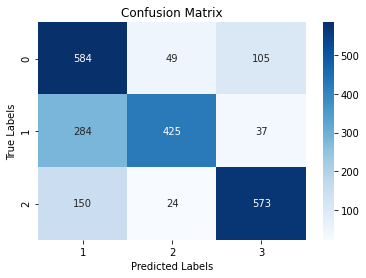

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

y_pred = []
y_true = []
threshold = 0.5

model.eval()
with torch.no_grad():
    for (labels, (text, text_len)), _ in test_iter:
        output = model(text, text_len)
        output = (output > threshold).int()
        y_pred.extend(output.tolist())
        y_true.extend(labels.tolist())

y_pred = [np.argmax(y) for y in y_pred]

print(y_pred)
print(y_true)

print('Classification Report:')
print(classification_report(y_true, y_pred, labels=np.unique(y_true), digits=4))

cm = confusion_matrix(y_true, y_pred, np.unique(y_true))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(np.unique(y_true))
ax.yaxis.set_ticklabels(np.unique(y_pred))
